Introduction and importing dependencies

In [1]:
!pip install --upgrade pip setuptools
!pip install tensorflow opencv-python matplotlib
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install --upgrade opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 3.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#importing tensor flow Dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


/Users/adarshkatigi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
#Limiting GPU Memory consumption growth so we do not run into out of memory exeption/error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

#List of All available GPUs(Currently list of GPUs is empty because my laptop does not come with any built-in GPU)
gpus

[]

In [6]:
#Defining Folder Structures
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative') 
ANC_PATH = os.path.join('data','anchor')

In [7]:
# #Creating the required directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

Unpacking Labelled Faces, Collecting Anchor/ Positive Images

In [8]:
import uuid

In [9]:
# We establish a connection to the webcam
cap = cv2.VideoCapture(0)

# Looping through every single frame in the webcam
while cap.isOpened():   
    # Return value is boolean and tells us if the video capture device is working
    # Frame returns the current frame as an image
    ret, frame = cap.read()

    frame = frame[200:200+250, 500:500+250, :]

    #Collecting Anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Creating unique name/filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
    #Collecting Positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write the anchor image to the path
        cv2.imwrite(imgname, frame)
        
    # Renders the returned frame in a window on the screen titled 'Image Captured'
    cv2.imshow('Image Captured', frame)
    
    # If the 'q' key is pressed then the system exits the current running window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Exiting....")
        break
    
# Release the webcam
cap.release()
# Destroy the specific window
cv2.destroyWindow('Image Captured')
# Ensure all windows are closed
cv2.destroyAllWindows()
print("Webcam released and all related windows closed")

2024-06-04 20:37:02.063 Python[12082:685755] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Exiting....
Webcam released and all related windows closed


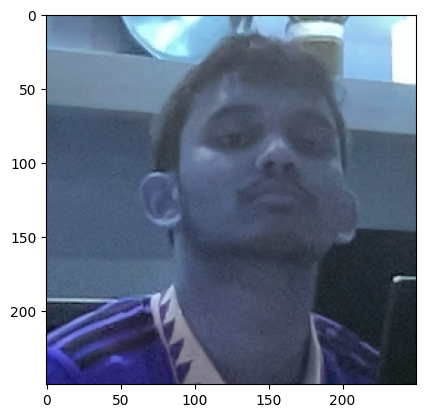

In [10]:
plt.imshow(frame)

In [11]:
#Fetching the image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [12]:
ANC_PATH+'/*.jpg'

'data/anchor/*.jpg'

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data/anchor/d9bd3b0c-1ea8-11ef-8d16-be8281faaadb.jpg'


In [15]:
#image preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) #load in the image using the decode method
    #Preprocessing steps
    img = tf.image.resize(img, (100, 100))#resizing image to be 100pX100pX3channels
    img = img/255.0 #Normalization
    return img

In [16]:
img = preprocess('data/anchor/dc84ffdc-1ea8-11ef-8d16-be8281faaadb.jpg')

In [17]:
#Printing the scale of the darkest to the lightest pixel
#Usually min() = 0 because the darkest pixel is black
#max() value is the lightest pixel . Here there is no field of white so the vlaue is slightly less than 1
print(img.numpy().min())
print("to")
print(img.numpy().max())

0.0
to
0.9884804


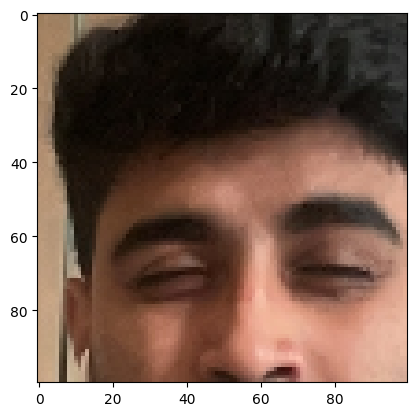

In [18]:
plt.imshow(img)

Creating Labelled Dataset

In [19]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [20]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [24]:
iterator_labs = class_labels.as_numpy_iterator()

In [22]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data=positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [29]:
samples.next()

(b'data/anchor/c2f4f0d0-1e18-11ef-8b17-be8281faaadb.jpg',
 b'data/positive/2081bd3c-1e19-11ef-8b17-be8281faaadb.jpg',
 1.0)